In [1]:
import torch
from data.datasets import UchuuVoxelizedData

exp_id = 'e5fc6bf518fa44d28292204205af8926'
project_path = '/pscratch/sd/d/dfarough/LargeScaleStructure'

lss = UchuuVoxelizedData(datafile='/pscratch/sd/d/dfarough/LSS_data/Uchuu1000-Pl18_z0p00_hlist_4.h5', 
                         box_size=128, 
                         voxel_size=64)

truth = lss.sample(voxel_idx=0, normalize=True)
gen_sample = torch.load(project_path + f'/{exp_id}/gen_sample.pt')

INFO: fetching data from /pscratch/sd/d/dfarough/LSS_data/Uchuu1000-Pl18_z0p00_hlist_4.h5 
INFO: voxelizing 1071151 points into 8 voxels within box size 128 Mpc


/global/u2/d/dfarough/LSSFlow/LSSFlow/data/datasets.py:110: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  ix = torch.bucketize(points[:, 0], boundaries, right=False) - 1


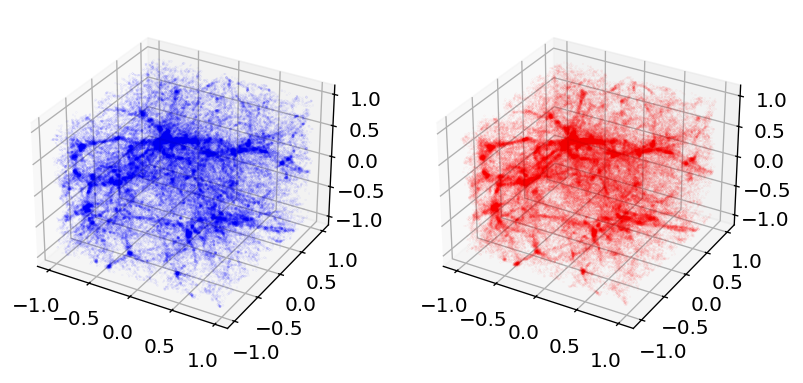

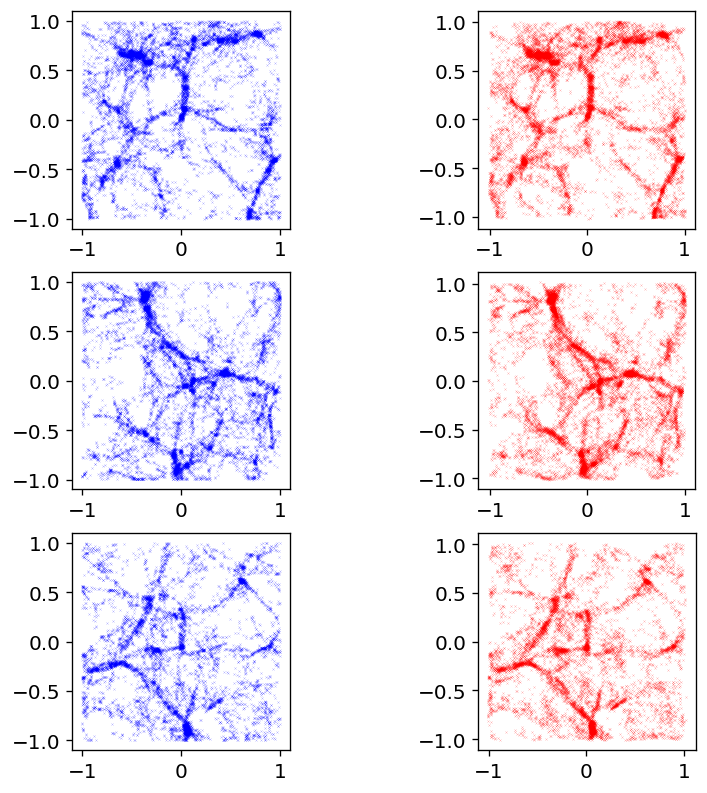

In [3]:
from utils.plotting import plot_lss_slices, plot_lss_results

plot_lss_results(truth, gen_sample, marker_size=0.001, alpha=0.5, figsize=(8,8))
plot_lss_slices(truth, gen_sample, marker_size=0.002, figsize=(8,8), alpha=1,marker='x')

In [22]:
import numpy as np  


def compute_power_spectrum_cube(points, box_size, grid_size):
    """
    Compute an approximate 3D power spectrum P(k) from a point cloud
    living inside a cubic box with periodic boundary conditions.

    Parameters
    ----------
    points : array_like, shape (N, 3)
        Galaxy positions in R^3, assumed to be in [-box_size/2, box_size/2) for each dimension.
    box_size : float
        Physical size of the cubic box.
    grid_size : int
        Number of grid cells per dimension for the voxel grid (e.g. 128 or 256).

    Returns
    -------
    k_vals : 1D ndarray
        Bin centers in k-space.
    Pk : 1D ndarray
        Spherically averaged power spectrum P(k) for each bin.
    """

    points = np.asarray(points, dtype=np.float32)

    # Shift points from [-box_size, box_size) to [0, 2*box_size)
    points = (points + 1.0) * (box_size / 2.0) 

    # Grid spacing
    dx = box_size / grid_size

    # Cloud-in-cell assignment of points to a 3D grid
    density = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    coords = points / dx  # convert to grid coordinates in [0, grid_size)

    for x, y, z in coords:
        i = int(np.floor(x)) % grid_size
        j = int(np.floor(y)) % grid_size
        k = int(np.floor(z)) % grid_size

        dx1 = x - i
        dy1 = y - j
        dz1 = z - k

        dx0 = 1.0 - dx1
        dy0 = 1.0 - dy1
        dz0 = 1.0 - dz1

        # Distribute mass to 8 neighbors (periodic boundary conditions)
        density[i,                   j,                   k                  ] += dx0 * dy0 * dz0
        density[(i + 1) % grid_size, j,                   k                  ] += dx1 * dy0 * dz0
        density[i,                   (j + 1) % grid_size, k                  ] += dx0 * dy1 * dz0
        density[i,                   j,                   (k + 1) % grid_size] += dx0 * dy0 * dz1
        density[(i + 1) % grid_size, (j + 1) % grid_size, k                  ] += dx1 * dy1 * dz0
        density[(i + 1) % grid_size, j,                   (k + 1) % grid_size] += dx1 * dy0 * dz1
        density[i,                   (j + 1) % grid_size, (k + 1) % grid_size] += dx0 * dy1 * dz1
        density[(i + 1) % grid_size, (j + 1) % grid_size, (k + 1) % grid_size] += dx1 * dy1 * dz1

    # Compute overdensity field δ = ρ / <ρ> - 1
    density_mean = np.mean(density)
    
    if density_mean == 0:
        raise ValueError("Mean density is zero; check input points / grid_size.")

    delta = density / density_mean - 1.0

    # FFT and power spectrum
    delta_k = np.fft.fftn(delta)
    delta_k = np.fft.fftshift(delta_k)
    power = np.abs(delta_k) ** 2

    # Construct k-grid and bin isotropically
    kfreq = np.fft.fftfreq(grid_size, d=dx)
    kfreq = np.fft.fftshift(kfreq)

    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    kk = np.sqrt(kx**2 + ky**2 + kz**2)

    k_flat = kk.ravel()
    p_flat = power.ravel()

    # Ignore k=0 mode
    nonzero = k_flat > 0
    k_flat = k_flat[nonzero]
    p_flat = p_flat[nonzero]

    # Bin in k (log-space)
    kmin = k_flat.min()
    kmax = k_flat.max()
    nbins = grid_size // 2

    k_edges = np.logspace(np.log10(kmin), np.log10(kmax), nbins + 1)
    bin_idx = np.digitize(k_flat, k_edges)

    k_vals = np.zeros(nbins)
    Pk = np.zeros(nbins)

    for b in range(1, nbins + 1):
        mask_b = bin_idx == b
        if np.any(mask_b):
            k_vals[b - 1] = np.mean(k_flat[mask_b])
            Pk[b - 1] = np.mean(p_flat[mask_b])
        else:
            k_vals[b - 1] = np.nan
            Pk[b - 1] = np.nan

    valid = ~np.isnan(Pk)
    return k_vals[valid], Pk[valid]



# Compute power spectrum for points in a cubic box
k_vals, Pk_truth = compute_power_spectrum_cube(truth, box_size=64, grid_size=200)
k_vals, Pk_gen = compute_power_spectrum_cube(gen_sample, box_size=64, grid_size=200)

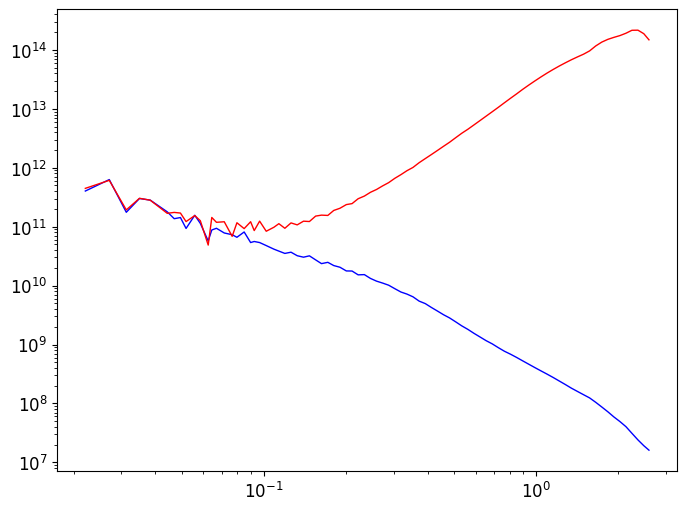

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))

# --- top panel ---
ax.loglog(k_vals, Pk_truth, label='truth', c='b', lw=1.)
ax.loglog(k_vals, Pk_gen, label='gen', c='r', lw=1.)

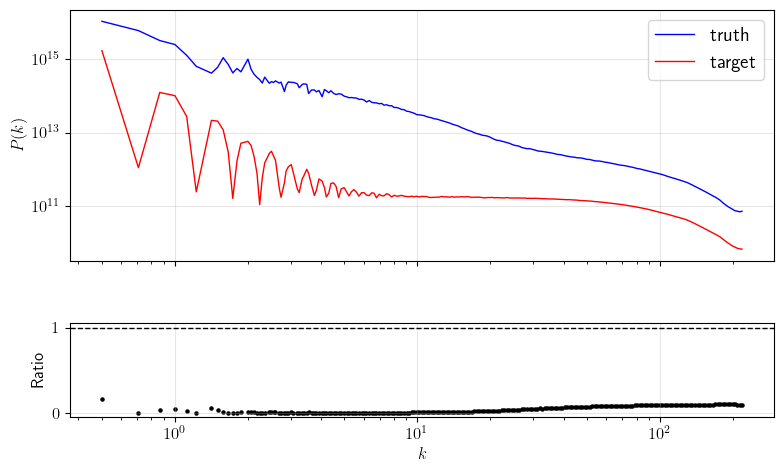

In [29]:
from utils import compute_power_spectrum_sphere, plot_power_spectrum_sphere

k, Pk_target = compute_power_spectrum_sphere(target_data[:10000], grid_size=512)
# _, Pk_source = compute_power_spectrum_sphere(source_data, grid_size=512)

plot_power_spectrum_sphere(k, Pk_target, Pk_source)

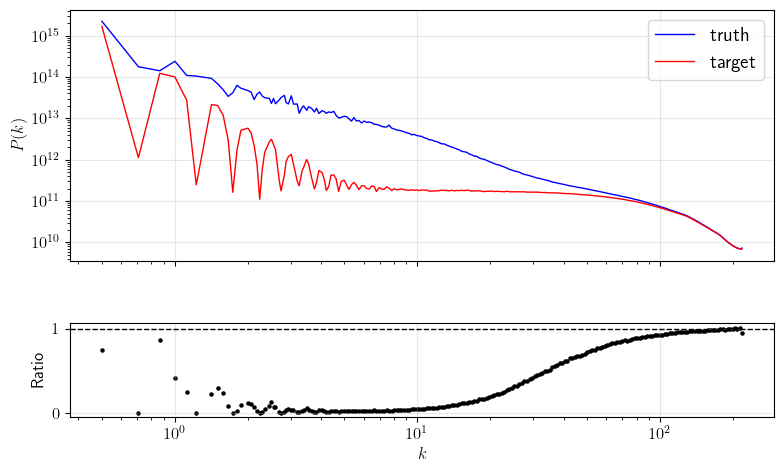

In [ ]:
from utils import compute_power_spectrum_sphere, plot_power_spectrum_sphere

k, Pk_target = compute_power_spectrum_sphere(target_data[:10000], grid_size=512)
_, Pk_source = compute_power_spectrum_sphere(source_data, grid_size=512)

plot_power_spectrum_sphere(k, Pk_target, Pk_source)

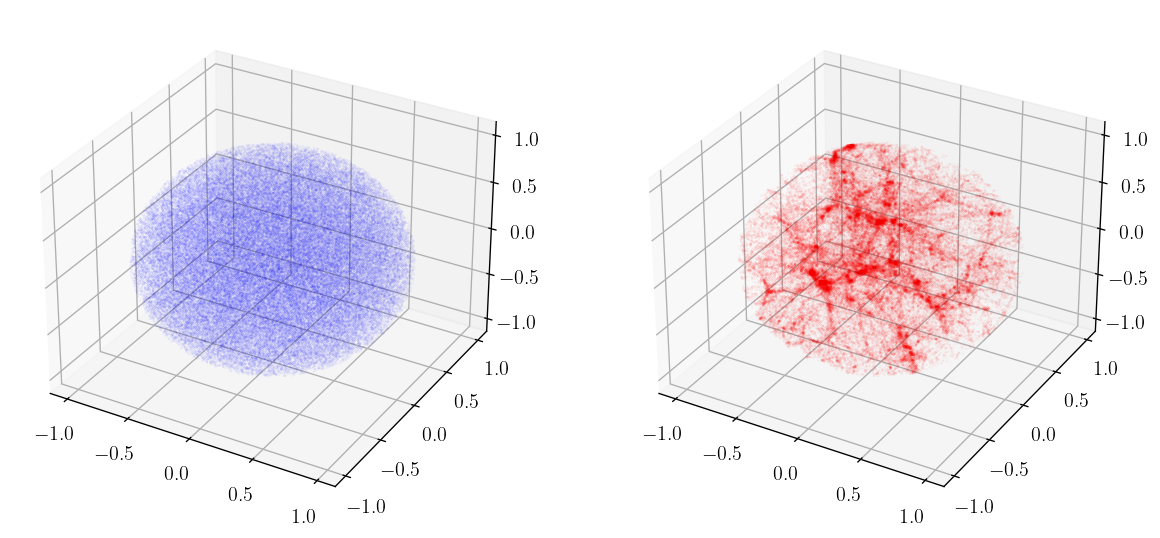

In [22]:
from utils import plot_lss_results

plot_lss_results(source_data, target_data, marker_size=0.001, alpha=0.5)

In [ ]:
import pytorch_lightning as L
from torch.utils.data import DataLoader
from cfm import ConditionalFlowMatching

from dataclasses import dataclass
from datasets import SphericalUniform, UchuuCentered, DataCoupling

#==================

@dataclass
class Config:
    exp_id = '4ccbb17faf71430d8be0ce5f33706c6e'
    ckpt = 'last'
    num_points = 100_000
    dim = 3
    dim_fourier = 256
    n_embd = 512
    num_blocks = 6
    dropout = 0.1
    sigma = 1e-4 # cfm hyperparameter
    flow = 'uniform'
    gamma = 1.0  # fourier feature hyperparameter
    batch_size = 1024
    mass_reg = 0.25
    use_mass_reg = True
    use_OT = True
    num_steps = 200

config = Config()

uniform_density = SphericalUniform(radius=1)
source_data = uniform_density.sample(num_points=config.num_points)

dataset = DataCoupling(source=source_data, target=None)
gen_dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)              

base_dir = '/home/df630/LargeScaleStructureFlows/Results/LargeScaleStructure/'
model = ConditionalFlowMatching.load_from_checkpoint(base_dir + config.exp_id +f'/checkpoints/{config.ckpt}.ckpt',  map_location="cpu", config=config)

trainer = L.Trainer(accelerator='gpu', devices=[0], inference_mode=False)
sample_batched = trainer.predict(model, gen_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/gaia_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/df630/.conda/envs/gaia_env/lib/python3.11/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [4]:
import torch

trajectories = torch.cat(sample_batched, dim=0)  # (N, num_timesteps, 3) 
trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
trajectories = trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
gen_sample = trajectories[-1]

torch.save(gen_sample, base_dir + config.exp_id + '/gen_sample.pt')

In [30]:
gen_sample.shape

torch.Size([100000, 3])

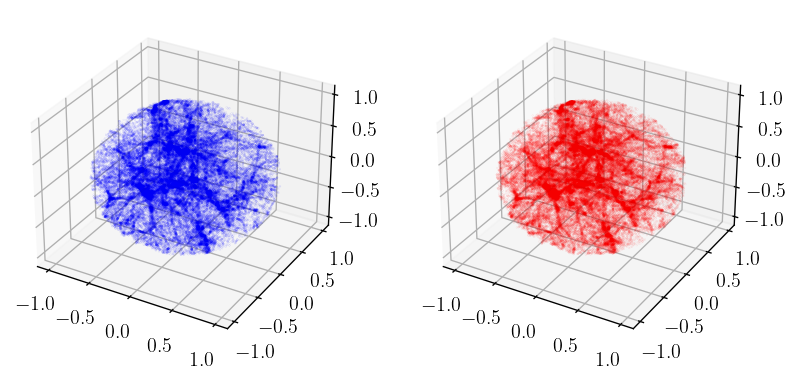

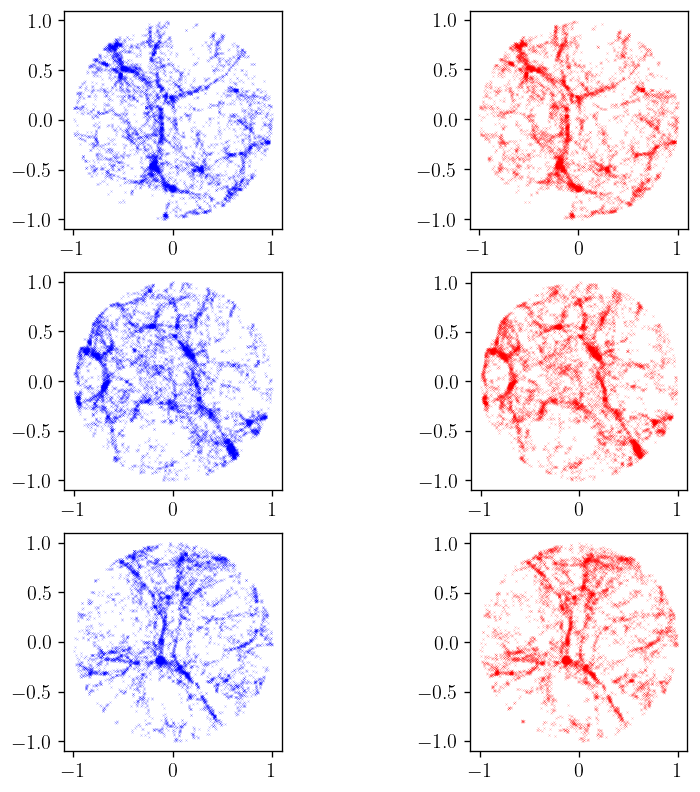

In [31]:
import matplotlib.pyplot as plt

from utils import plot_lss_results, plot_lss_slices

plot_lss_results(target_data[:100000], gen_sample, marker_size=0.001, alpha=0.75, figsize=(8,8))
plot_lss_slices(target_data[:100000], gen_sample, marker_size=0.002, figsize=(8,8), alpha=1,marker='x')


In [6]:
from utils import compute_power_spectrum_sphere, plot_power_spectrum_sphere

k, Pk_gen = compute_power_spectrum_sphere(gen_sample, grid_size=512)


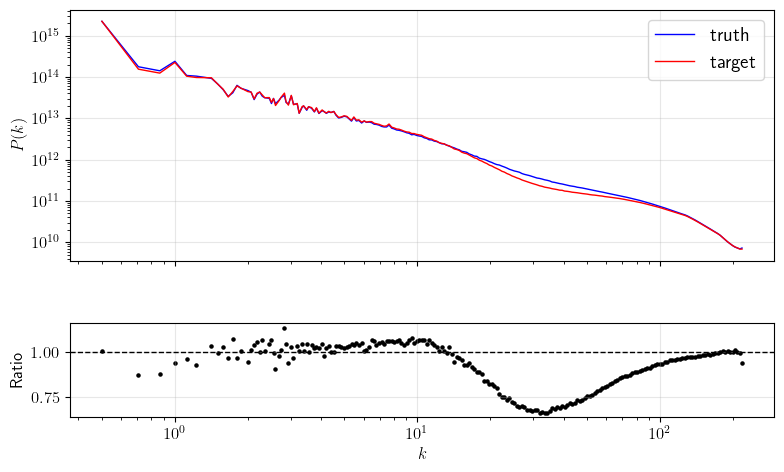

In [25]:
plot_power_spectrum_sphere(k, Pk_target, Pk_gen)

## Free-Fall Flow

In [9]:
import pytorch_lightning as L
from torch.utils.data import DataLoader
from cfm import ConditionalFlowMatching

from dataclasses import dataclass
from datasets import SphericalUniform, UchuuCentered, DataCoupling

#==================

@dataclass
class Config:
    exp_id = 'c5a2d062efde43b0a0383bffbecd86c9'
    ckpt = 'best'
    num_points = 100_000
    dim = 3
    dim_fourier = 256
    n_embd = 512
    num_blocks = 6
    dropout = 0.1
    sigma = 1e-4 # cfm hyperparameter
    flow = 'freefall'
    gamma = 1.0  # fourier feature hyperparameter
    batch_size = 1024
    mass_reg = 0.25
    use_mass_reg = True
    use_OT = True
    num_steps = 200

config = Config()

uniform_density = SphericalUniform(radius=1)
source_data = uniform_density.sample(num_points=config.num_points)

dataset = DataCoupling(source=source_data, target=None)
gen_dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)              

base_dir = '/home/df630/LargeScaleStructureFlows/Results/LargeScaleStructure/'
model = ConditionalFlowMatching.load_from_checkpoint(base_dir + config.exp_id +f'/checkpoints/{config.ckpt}.ckpt',  map_location="cpu", config=config)

trainer = L.Trainer(accelerator='gpu', devices=[0], inference_mode=False)
sample_batched = trainer.predict(model, gen_dataloader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/gaia_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
import torch

trajectories = torch.cat(sample_batched, dim=0)  # (N, num_timesteps, 3) 
trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
trajectories = trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
gen_sample_freefall = trajectories[-1]

torch.save(gen_sample_freefall, base_dir + config.exp_id + '/gen_sample.pt')

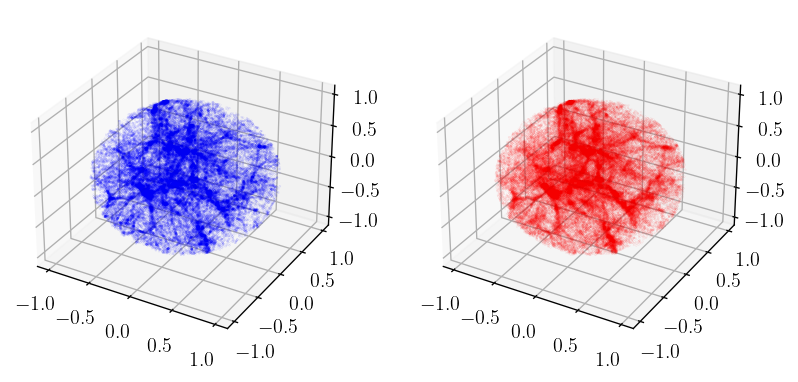

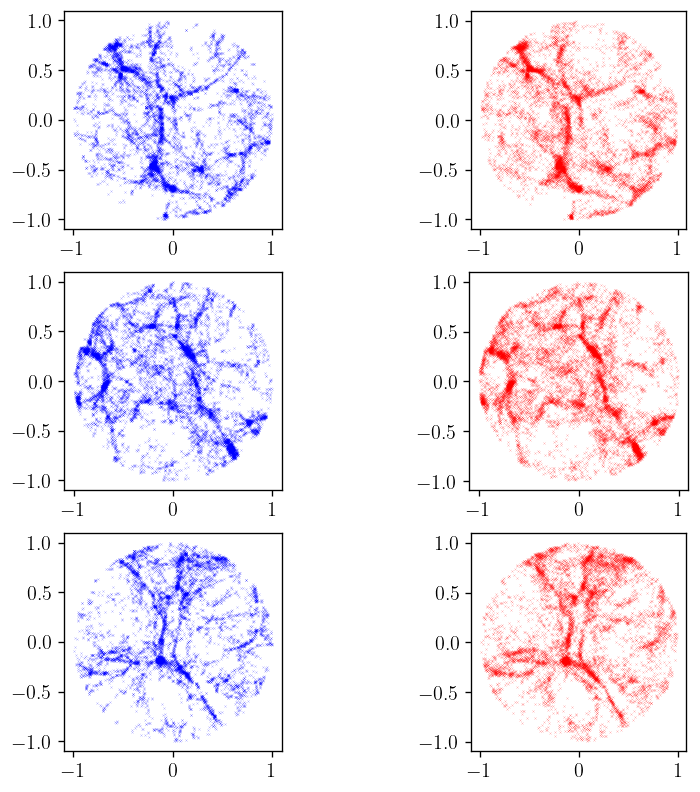

In [14]:
plot_lss_results(target_data, gen_sample_freefall, marker_size=0.001, alpha=0.75, figsize=(8,8))
plot_lss_slices(target_data, gen_sample_freefall, marker_size=0.002, figsize=(8,8), alpha=1,marker='x')

In [12]:
k, Pk_gen_freefall = compute_power_spectrum_sphere(gen_sample_freefall, grid_size=512)

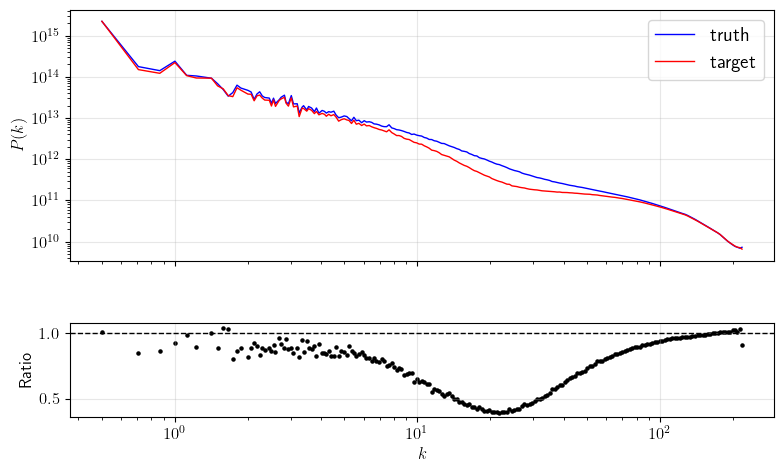

In [28]:
from utils import compute_power_spectrum_sphere, plot_power_spectrum_sphere

plot_power_spectrum_sphere(k, Pk_target, Pk_gen_freefall)

In [27]:
gen_sample_freefall.shape

torch.Size([100000, 3])